In [1]:
import crispr_hmm
from Bio import SeqIO
import random
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
import csv
import pandas as pd
import re

/homes8/jingyuan/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
ref = "GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGACGATGGAGTCGCGAGCGCTATGAGCGACTATGGAGTCGATACGATACGCGCACGCTATGGAGTCGAGAGCGCGCTCGTCGACTATGGAGTCGCGACTGTACGCACACGCGATGGAGTCGATAGTATGCGTACACGCGATGGAGTCGAGTCGAGACGCTGACGATATGGAGTCGATACGTAGCACGCAGACGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC"
HMM_result = pd.read_csv("./output/HMM_carlin_result.csv")
NW_result = pd.read_csv("./output/NW_carlin_result.csv")

In [3]:
HMM_result

,aligned_ref,aligned_read,score
0,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924
1,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924
2,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924
3,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924
4,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924
...,...,...,...
1027718,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGA----...,-132.572057
1027719,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-133.193058
1027720,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-133.193058
1027721,-GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGA...,TGAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGA---...,-130.301200


In [4]:
def alignment_to_cigar(seq1, seq2):
    cigar = []
    count = 1
    last = None

    for a, b in zip(seq1, seq2):
        if a == '-' or b == '-':
            kind = 'D' if b == '-' else 'I'
        else:
            kind = 'M'

        if last == kind:
            count += 1
        else:
            if last is not None:
                cigar.append(f"{count}{last}")
            count = 1
            last = kind

    if count > 0:
        cigar.append(f"{count}{last}")

    return "".join(cigar)

In [5]:
HMM_result['cigar'] = HMM_result.apply(lambda row: alignment_to_cigar(row['aligned_ref'], row['aligned_read']), axis=1)
HMM_result

,aligned_ref,aligned_read,score,cigar
0,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924,36M24D8M5D23M192D37M1D21M
1,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924,36M24D8M5D23M192D37M1D21M
2,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924,36M24D8M5D23M192D37M1D21M
3,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924,36M24D8M5D23M192D37M1D21M
4,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-138.209924,36M24D8M5D23M192D37M1D21M
...,...,...,...,...
1027718,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGA----...,-132.572057,42M192D21M11D19M12D50M
1027719,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-133.193058,36M250D61M
1027720,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,-133.193058,36M250D61M
1027721,-GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGA...,TGAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGA---...,-130.301200,1I42M216D89M


In [6]:
def split_cigar(cigar):
    return [(int(n), t) for n, t in re.findall(r'(\d+)([MIDNSHP=X])', cigar)]

In [7]:
def find_mutation_start(cigar,mutation_type):
    cigar_list = split_cigar(cigar)
    result = []
    l = 0
    for e, t in cigar_list:
        if t == mutation_type:
            result.append(l+1)
        if t != "I":
            l += e
    return result

In [8]:
HMM_deletion_start = []

for cigar in HMM_result['cigar']:
    HMM_deletion_start += find_mutation_start(cigar,"D")

In [9]:
NW_result['cigar'] = NW_result.apply(lambda row: alignment_to_cigar(row['aligned_ref'], row['aligned_read']), axis=1)
NW_result

,aligned_ref,aligned_read,score,cigar
0,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGAC----------...,188.2,36M24D8M5D20M192D40M1D21M
1,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGC---------------...,188.2,31M24D12M5D20M192D40M1D22M
2,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACG------------...,188.2,34M24D8M5D21M192D41M1D21M
3,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACG------------...,188.2,34M24D10M5D19M192D41M1D21M
4,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTG----------------...,188.2,30M24D12M5D23M192D39M1D21M
...,...,...,...,...
1027718,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGA----...,208.8,42M192D20M11D20M12D50M
1027719,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGA-----------...,155.1,35M250D62M
1027720,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGA-----------...,155.1,35M250D62M
1027721,-GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGA...,TGAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGA---...,212.5,1I42M216D89M


In [10]:
NW_deletion_start = []

for cigar in NW_result['cigar']:
    NW_deletion_start += find_mutation_start(cigar,"D")

In [11]:
position_tick = [-100 for _ in range(22)] + [i-24 for i in range(27)] * 10 + [-100 for _ in range(57)]
len(position_tick)

349

In [12]:
HMM_deletion_relative_start = [position_tick[i] for i in HMM_deletion_start]
HMM_deletion_relative_start = [i for i in HMM_deletion_relative_start if i!= -100]
NW_deletion_relative_start = [position_tick[i] for i in NW_deletion_start]
NW_deletion_relative_start = [i for i in NW_deletion_relative_start if i!= -100]

In [13]:
bin_edges = [i-24.5 for i in range(28)]

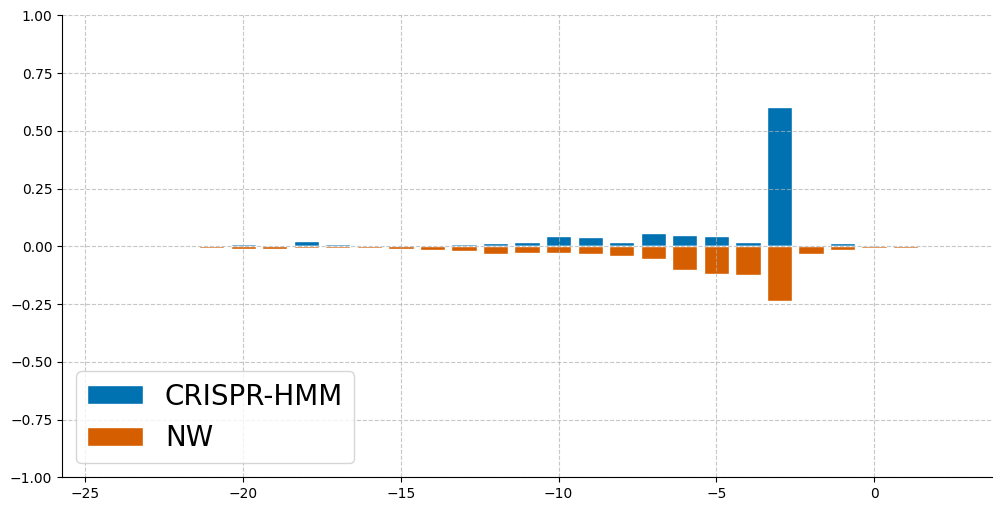

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_deletion_relative_start) / len(HMM_deletion_relative_start)
weights2 = np.ones_like(NW_deletion_relative_start) / len(NW_deletion_relative_start)

plt.hist(HMM_deletion_relative_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_deletion_relative_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
# ax.set_xticks(pos)
# ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-1., 1.))

# Add title
# ax.set_title("Bar plot", fontsize=16)

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()

In [15]:
bin_edges = [i-.5 for i in range(len(ref)+2)]

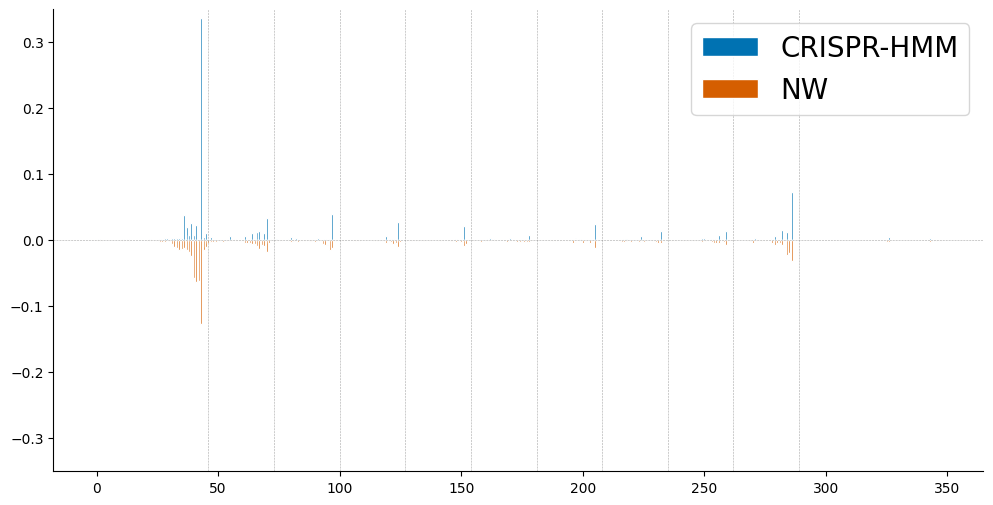

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_deletion_start) / len(HMM_deletion_start)
weights2 = np.ones_like(NW_deletion_start) / len(NW_deletion_start)

plt.hist(HMM_deletion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_deletion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
# ax.set_xticks(pos)
# ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-.35, .35))

# Add title
# ax.set_title("Bar plot", fontsize=16)

for i in [i for i in range(len(position_tick)) if position_tick[i]==0]:
    ax.axvline(x=i, color='gray', linestyle='--', linewidth=0.4, alpha=0.7)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.4, alpha=0.7)
# Customize grid
# ax.xaxis.grid(True, linestyle='--', alpha=0.7)
# ax.yaxis.grid(True, linestyle='--', alpha=0.7)
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend
ax.legend(loc='upper right', fontsize=20)

# Show the plot
plt.show()

In [17]:
HMM_insertion_start = []
for cigar in HMM_result['cigar']:
    HMM_insertion_start += find_mutation_start(cigar,"I")
    
NW_insertion_start = []
for cigar in NW_result['cigar']:
    NW_insertion_start += find_mutation_start(cigar,"I")

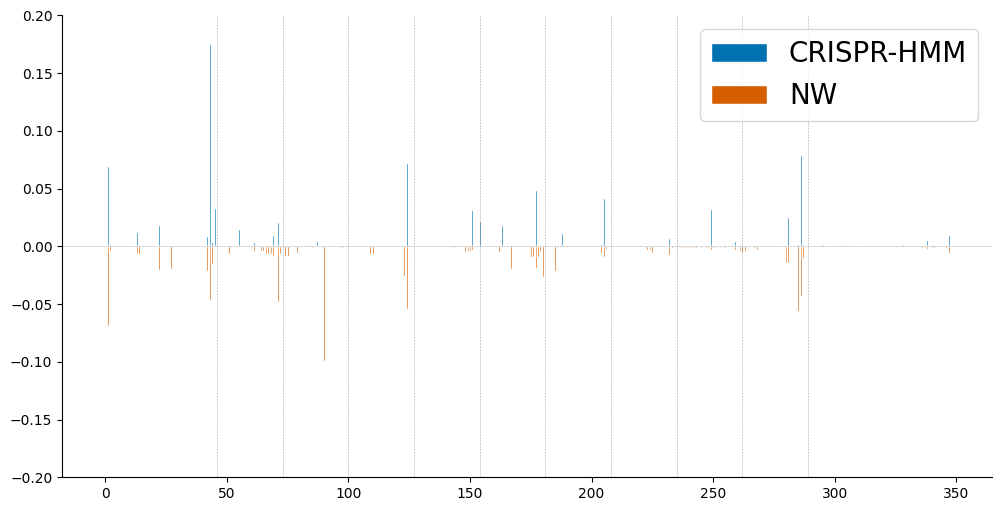

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_insertion_start) / len(HMM_insertion_start)
weights2 = np.ones_like(NW_insertion_start) / len(NW_insertion_start)

plt.hist(HMM_insertion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_insertion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
# ax.set_xticks(pos)
# ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-.2, .2))

# Add title
# ax.set_title("Bar plot", fontsize=16)
for i in [i for i in range(len(position_tick)) if position_tick[i]==0]:
    ax.axvline(x=i, color='gray', linestyle='--', linewidth=0.4, alpha=0.7)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.4, alpha=0.7)
# Customize grid
# ax.xaxis.grid(True, linestyle='--', alpha=0.7)
# ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend
ax.legend(loc='upper right', fontsize=20)

# Show the plot
plt.show()

In [19]:
HMM_insertion_relative_start = [position_tick[i] for i in HMM_insertion_start]
HMM_insertion_relative_start = [i for i in HMM_insertion_relative_start if i!= -100]
NW_insertion_relative_start = [position_tick[i] for i in NW_insertion_start]
NW_insertion_relative_start = [i for i in NW_insertion_relative_start if i!= -100]

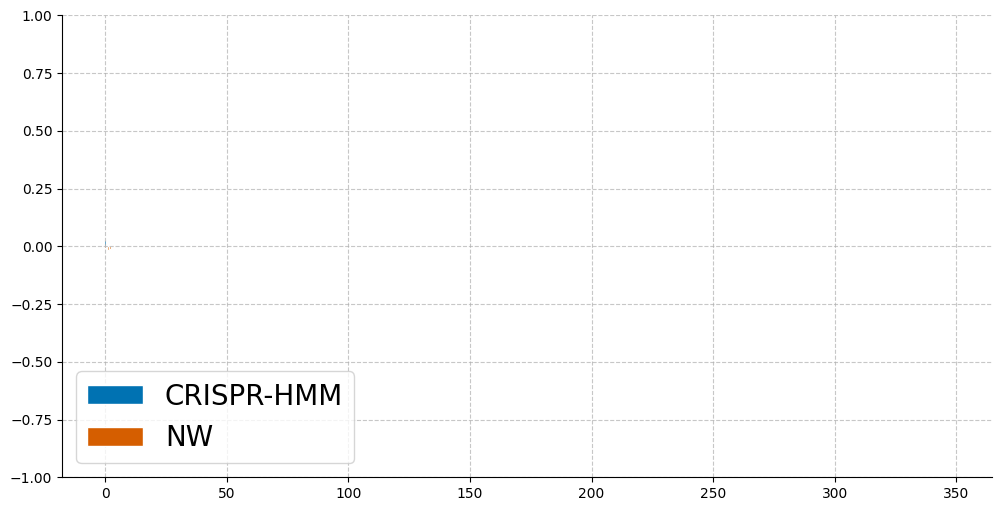

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_insertion_relative_start) / len(HMM_insertion_relative_start)
weights2 = np.ones_like(NW_insertion_relative_start) / len(NW_insertion_relative_start)

plt.hist(HMM_insertion_relative_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_insertion_relative_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
# ax.set_xticks(pos)
# ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-1., 1.))

# Add title
# ax.set_title("Bar plot", fontsize=16)

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()